# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# Issues
1. Only the mu_a's are changed, not any of the other properties! 
2. Fetal performance is not nearly as good as maternal. This could be due to the noise in the far ends of the plots. Maybe interpolation would help?
3. Fetal errors: Sat: ~3% Sat., Conc: ~1.9


# Notes
1. Using interpolated values seems to make the fitting more stable. Not better however.
2. Maternal is very good.
3. Fetal just estimates a mean!

# Things to Try
1. Fetal | Maternal = known

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc.pkl')
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, 0.8])
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,SDD,Intensity,Wave Int,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation
0,10,-4.965775,1.0,6.0,12.0,0.9,0.11,0.1
1,14,-7.347777,1.0,6.0,12.0,0.9,0.11,0.1
2,19,-9.090567,1.0,6.0,12.0,0.9,0.11,0.1
3,23,-9.968481,1.0,6.0,12.0,0.9,0.11,0.1
4,28,-10.706361,1.0,6.0,12.0,0.9,0.11,0.1


In [3]:
data = create_ratio_and_intensity(data, True)
# data = create_ratio(data, True)
# data = create_spatial_intensity(data)

data.head() 
# NOTE: Have only 1 on at the same time!

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10,14,19,23,28,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,-0.480386,-2.623673,-4.576879,-5.702919,-6.686932,...,-11.358381,-11.711740,-12.210222,-12.655790,-13.271930,-13.812146,-14.545983,-15.179238,-16.027416,-16.750309
1,2.0,12.0,0.9,0.11,0.225,-0.481023,-2.627596,-4.588893,-5.722310,-6.715494,...,-11.382127,-11.737660,-12.238768,-12.686365,-13.304953,-13.847055,-14.583165,-15.218171,-16.068457,-16.792972
2,2.0,12.0,0.9,0.11,0.350,-0.481700,-2.631798,-4.601607,-5.742794,-6.745674,...,-11.405223,-11.762845,-12.266471,-12.716009,-13.336930,-13.880828,-14.619094,-15.255757,-16.108029,-16.834069
3,2.0,12.0,0.9,0.11,0.475,-0.482420,-2.636328,-4.615141,-5.764560,-6.777781,...,-11.427687,-11.787314,-12.293352,-12.744741,-13.367884,-13.913485,-14.653790,-15.292014,-16.146153,-16.873619
4,2.0,12.0,0.9,0.11,0.600,-0.483187,-2.641256,-4.629645,-5.787851,-6.812205,...,-11.449536,-11.811086,-12.319428,-12.772583,-13.397835,-13.945047,-14.687274,-15.326963,-16.182847,-16.911642


In [4]:
# Cleanup
data.dropna(inplace=True)

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [5]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
y_columns = ['Maternal Saturation']
# y_columns = ['Maternal Hb Concentration']
# y_columns = ['Fetal Saturation']
# y_columns = ['Fetal Hb Concentration']

## X -> Predictors
x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))

## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])



## Model Configuration

In [6]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)
model_config = {
    # 'model_class' : SplitChannelCNN,  # Class name
    'model_class' : PerceptronReLU,  # Class name
    # 'model_params' :  [2, IN_FEATURES, 4, 5, [2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 5, [6, 3, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 7, [3, OUT_FEATURES]],    # Input params as an array
    'model_params' :  [[IN_FEATURES, 8, OUT_FEATURES]],    # Input params as an array
    'validation' : RandomSplit(0.8),
    'epochs' : 100,
    
}

In [7]:
# Custom Train Function 
def train_model2(iteration_config, epoch=60):
    np.random.seed(70)  # Set seed for consistentcy
    params = {
        'batch_size': iteration_config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['validation'])
    # model = create_perceptron_model(config['model'])
    # model = create_perceptron_model([42, 8, 1])
    # model = TwoChannelCNN(40, 4, 5, [4, 1])
    model = model_config['model_class'](*model_config['model_params'])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=iteration_config["lr"], momentum=iteration_config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [ ]:
# Hyper Parameter Search 
iteration_config = {
    "lr" : tune.loguniform(1e-5, 1e-3),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([32, 16, 8]),
    # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.choice([0.93, 0.95, 0.97]),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=40, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [ ]:
best_trial.config

In [ ]:
model_config

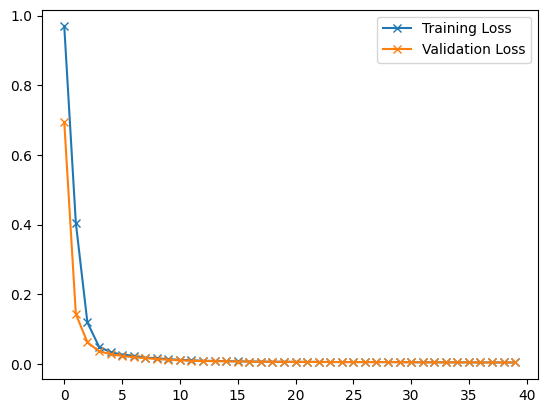

In [8]:
# Train Model with the given params.
np.random.seed(70)  # Set seed for consistentcy
params = {
    'batch_size': 128, 'shuffle': True, 'num_workers': 2
}
# params['batch_size'] = best_trial.config['batch_size']
train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['validation'])
model = model_config['model_class'](*model_config['model_params'])
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
optimizer = SGD(model.parameters(), lr=0.003, momentum=0.95)
# optimizer = SGD(model.parameters(), lr=best_trial.config['lr'], momentum=best_trial.config['momentum'])
# CUDA_VISIBLE is already set to only see one GPU
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=40, gpu_to_use=0)
# train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=model_config['epochs'], gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [9]:
print(f'Train MSE : {train_loss[-1]}, Val MSE : {validation_loss[-1]}')

Train MSE : 0.0043219277140451595, Val MSE : 0.0044085731788072735


In [ ]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    # error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error})
plt.figure()
error_df['%tage'].plot.hist(bins=100)
# plt.xlabel('(%) Error')
plt.xlabel('Abs. Sat. Error')
plt.ylabel('Count')
plt.show()

In [ ]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]
combined_table = data.join(error_df)
with pd.option_context("display.max_rows", None):
    display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

In [ ]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

In [10]:
# Model Info
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PerceptronReLU                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       488
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       9
│    └─Flatten: 2-4                      --
Total params: 497
Trainable params: 497
Non-trainable params: 0

In [ ]:
error_df.columns

In [11]:
model_name = 'msat_percep_irsi'
import joblib
# Save Model
torch.save(model.state_dict(), rf'../models/{model_name}')
# Save the Scalers for Later Use
joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

['../models/msat_percep_irsi_yscaler']

In [ ]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')